In [8]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# UCI wine 데이터 불러오기
column_names = ['Class','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium',
                'Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins',
                'Color intensity','Hue','OD280/OD315','Proline']

data = pd.read_csv("wine.data", header=None, names=column_names)

# 클래스 1과 2만 사용 (이진분류)
binary_data = data[data['Class'].isin([1,2])]
binary_data['Class'] = binary_data['Class'].map({1:0, 2:1})

X = binary_data.drop('Class', axis=1).values
y = binary_data['Class'].values.flatten()

# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Data Loaded:", X.shape, y.shape)


Data Loaded: (130, 13) (130,)


In [9]:
# Logistic Regression (기준 성능 측정용)
model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=100000)
model.fit(X, y)

# Baseline loss (L*)
baseline_loss = log_loss(y, model.predict_proba(X))
print(f"Baseline Logistic Loss L*: {baseline_loss:.8f}")


Baseline Logistic Loss L*: 0.00000073


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [11]:
import random as ran

def random_coordinate_descent(X, y, max_iter=50000, learning_rate=0.01, tol=1e-5):
    m, n = X.shape
    loss_history = []
    iteration_history = []

    w = np.zeros(n)

    for iter in range(max_iter):
        i = ran.choice(range(n))
        y_pred = sigmoid(X.dot(w))
        diff = y_pred - y
        grad = diff.dot(X[:, i]) / m
        w[i] -= learning_rate * grad

        if iter % 100 == 0:
            loss = log_loss(y, sigmoid(X.dot(w)))
            loss_history.append(loss)
            iteration_history.append(iter)

            if loss < tol:
                break

    return w, loss_history, iteration_history


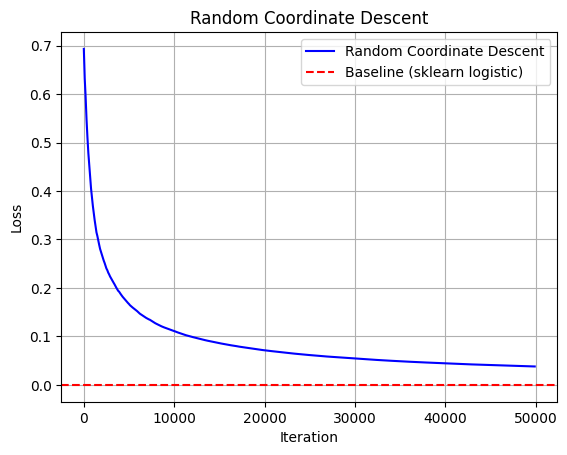

In [17]:
# 함수 실행
weights_rand, loss_history_rand, iteration_history_rand = random_coordinate_descent(X, y)

# 그래프 출력
plt.plot(iteration_history_rand, loss_history_rand, label='Random Coordinate Descent', color='blue')
plt.axhline(y=baseline_loss, color='red', linestyle='--', label='Baseline (sklearn logistic)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Random Coordinate Descent')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def greedy_coordinate_descent(X, y, max_iter=50000, learning_rate=0.01, tol=1e-5):
    m, n = X.shape
    loss_history = []
    iteration_history = []

    w = np.zeros(n)

    for iter in range(max_iter):
        y_pred = sigmoid(X.dot(w))
        diff = y_pred - y
        grad = diff.dot(X) / m

        max_grad_index = np.argmax(np.abs(grad))
        max_grad = grad[max_grad_index]

        w[max_grad_index] -= learning_rate * max_grad

        if iter % 100 == 0:
            loss = log_loss(y, sigmoid(X.dot(w)))
            loss_history.append(loss)
            iteration_history.append(iter)

            if loss < tol:
                break

    return w, loss_history, iteration_history


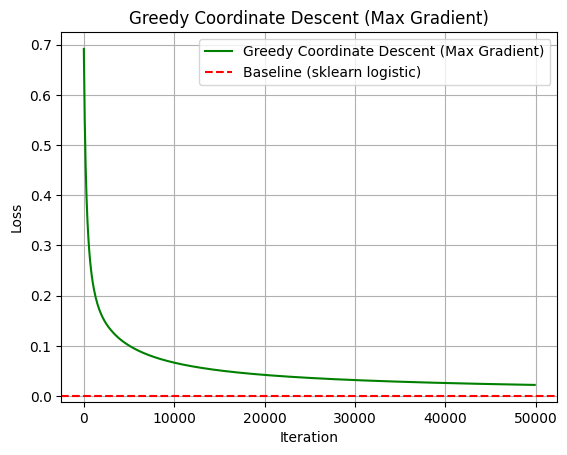

In [19]:
weights_grad, loss_history_grad, iteration_history_grad = greedy_coordinate_descent(X, y)

# 그래프 출력
plt.plot(iteration_history_grad, loss_history_grad, label='Greedy Coordinate Descent (Max Gradient)', color='green')
plt.axhline(y=baseline_loss, color='red', linestyle='--', label='Baseline (sklearn logistic)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Greedy Coordinate Descent (Max Gradient)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def adaptive_coordinate_descent(X, y, max_iter=50000, learning_rate=0.1, decay_rate=1e-4, tol=1e-5):
    m, n = X.shape
    loss_history = []
    iteration_history = []
    w = np.zeros(n)

    for iter in range(max_iter):
        y_pred = sigmoid(X.dot(w))
        diff = y_pred - y
        grad = diff.dot(X) / m

        max_grad_index = np.argmax(np.abs(grad))
        max_grad = grad[max_grad_index]

        w[max_grad_index] -= learning_rate * max_grad
        learning_rate = learning_rate / (1 + decay_rate * iter)  # Adaptive Learning Rate

        if iter % 100 == 0:
            loss = log_loss(y, sigmoid(X.dot(w)))
            loss_history.append(loss)
            iteration_history.append(iter)

            if loss < tol:
                break

    return w, loss_history, iteration_history


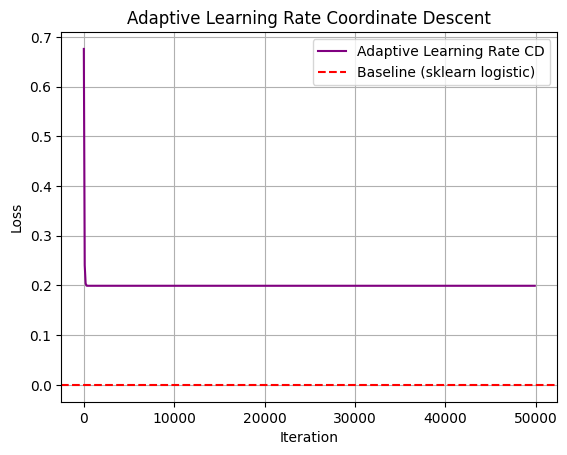

In [20]:
weights_adap, loss_history_adap, iteration_history_adap = adaptive_coordinate_descent(X, y)

# 그래프 출력
plt.plot(iteration_history_adap, loss_history_adap, label='Adaptive Learning Rate CD', color='purple')
plt.axhline(y=baseline_loss, color='red', linestyle='--', label='Baseline (sklearn logistic)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Adaptive Learning Rate Coordinate Descent')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# 실행 및 테스트
_, loss_random, iter_random = random_coordinate_descent(X, y)
_, loss_greedy, iter_greedy = greedy_coordinate_descent(X, y)
_, loss_adaptive, iter_adaptive = adaptive_coordinate_descent(X, y)

print("최종 손실값 (Random):", loss_random[-1])
print("최종 손실값 (Greedy):", loss_greedy[-1])
print("최종 손실값 (Adaptive):", loss_adaptive[-1])


최종 손실값 (Random): 0.03822113291392351
최종 손실값 (Greedy): 0.02207134443116343
최종 손실값 (Adaptive): 0.19936454328347405


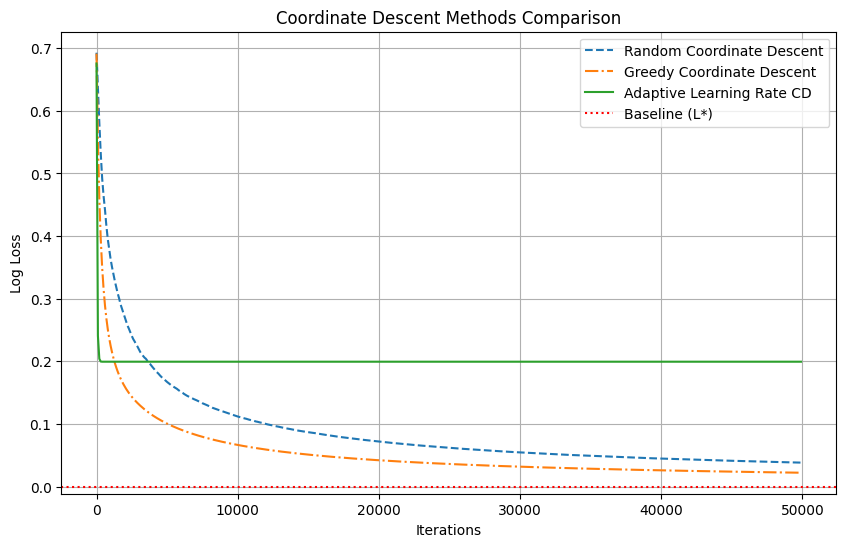

In [22]:
plt.figure(figsize=(10, 6))

# Random
plt.plot(iter_random, loss_random, label='Random Coordinate Descent', linestyle='--')

# Greedy
plt.plot(iter_greedy, loss_greedy, label='Greedy Coordinate Descent', linestyle='-.')

# Adaptive
plt.plot(iter_adaptive, loss_adaptive, label='Adaptive Learning Rate CD', linestyle='-')

# Baseline L*
plt.axhline(y=baseline_loss, color='red', linestyle=':', label='Baseline (L*)')

plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Coordinate Descent Methods Comparison')
plt.legend()
plt.grid(True)
plt.show()
